In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

# Load MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Preprocess the data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

# Define the generator model
generator = Sequential([
    Dense(128, input_shape=(100,)),
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dense(784, activation='tanh'),
    Reshape((28, 28, 1))
])

# Define the discriminator model
discriminator = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128),
    LeakyReLU(alpha=0.2),
    Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Combined model (stack generator on discriminator)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan_model = Model(z, validity)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Training function
def train(epochs, batch_size=128, sample_interval=50):
    for epoch in range(epochs):
        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan_model.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print progress
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

            # Save generated images
            save_images(epoch)

# Function to save generated images
def save_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0-1

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.close()

# Train the GAN
train(epochs=600, batch_size=32, sample_interval=200)

# Save the trained GAN model to an .h5 file
gan_model.save("gan_model.h5")


1/1 [==============================] - 0s 270ms/step
Epoch 0, D Loss: 0.616228774189949, G Loss: 0.45560193061828613
1/1 [==============================] - 0s 18ms/step
Epoch 200, D Loss: 0.1363225094974041, G Loss: 2.9604432582855225
1/1 [==============================] - 0s 18ms/step
Epoch 400, D Loss: 0.9206668436527252, G Loss: 1.1574126482009888
1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Welcome to Interactive Storytelling!
Enter your prompt to start generating a story, or type 'exit' to quit.
Enter the ending of the story: Once upon a time there lived a knight in a magical kingdom


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1/1 [==============================] - 0s 107ms/step

Generated Story:
King: 
Queen: 
Knight: Once upon a time there lived a Knight 』 with a dark spirit and a strong magic, he sent forth a great wave. After taking down the castle master's head and the black knights to bring forth a great sword, the great wave instantly entered the enemy's hand. This moment, not even the enemies are able to block the great wave!

The king's name was Ye Xiwen and not Long Haochen who was fighting the King's army, and Long Haochen called his eyes wide wide and looked as if he had seen countless times all time.

After Long Haochen had already entered the battle field, the black knights who came with the great wave immediately rushed over the Great Wall.

Ye Xiwen immediately stood there as if waiting.

"Little King, I sent you on the mission…"

A knight immediately charged forward at the back and followed shortly.

"Big Brother… you must understand, this is the only time I have used magic on your father bu

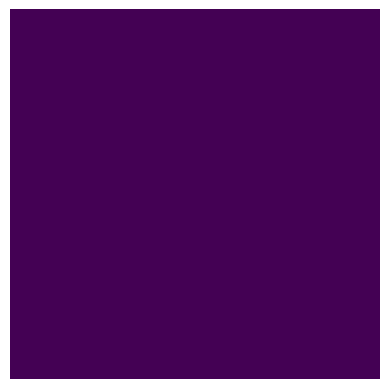

In [ ]:
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

# Load the text generation pipeline with GPT-2 model
generator = pipeline("text-generation", model="gpt2")

# Load the GAN model
gan_model = load_model("gan_model.h5")

def generate_story(prompt, character_names, ending, max_length=400):
    # Generate text based on input prompt
    story = generator(prompt, max_length=max_length, num_return_sequences=1)[0]['generated_text']

    # Combine character names with story
    characters_section = "\n".join([f"{name}: " for name in character_names])
    full_story = f"{characters_section}{story} {ending}"

    return full_story

def generate_image_with_gan(prompt):
    # Generate image using GAN model
    latent_dim = 100
    generated_image = gan_model.predict(np.random.normal(0, 1, (1, latent_dim)))[0]

    # Convert image array to PIL image
    generated_image = Image.fromarray((generated_image * 255).astype(np.uint8))

    return generated_image

def main():
    print("Welcome to Interactive Storytelling!")
    print("Enter your prompt to start generating a story, or type 'exit' to quit.")

    while True:
        prompt = input("Enter your prompt: ")

        if prompt.lower() == 'exit':
            print("Exiting...")
            break

        num_characters = int(input("Enter the number of characters: "))
        character_names = []
        for i in range(num_characters):
            name = input(f"Enter name for character {i + 1}: ")
            character_names.append(name)

        ending = input("Enter the ending of the story: ")

        # Generate and display the story
        full_story = generate_story(prompt, character_names, ending)
        generated_image = generate_image_with_gan(prompt)

        print("\nGenerated Story:")
        print(full_story)

        print("\nGenerated Image:")
        plt.imshow(generated_image)
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    main()
